In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# training parameters
lr_gen = 0.001
lr_disc = 0.001

epochs = 20000
batch_size = 32

disp_step = 500
examples_to_show = 10

In [3]:
# network parameters 
num_in = 784
hidd_gen = 256
hidd_disc = 256
latent = 200

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

#LeakyReLU activation
def leakyrelu(x, alpha=0.2):
    return 0.5 * (1 + alpha) * x + 0.5 * (1 - alpha) * abs(x)

# PLACEHOLDERS INPUTS
noise_input = tf.placeholder(tf.float32, shape=[None, latent])
real_input  = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
training_true = tf.placeholder(tf.bool)


In [4]:
# DEFINE MODEL wrappers

# Generator Network
# Input: Noise (latent), Output: Image
# Note that batch normalization has different behavior at training and inference time,
# we then use a placeholder to indicates the layer if we are training or not.
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        lay = tf.layers.dense(x, units=7*7*128)
        lay = tf.layers.batch_normalization(lay, training=training_true)
        lay = tf.nn.relu(lay)
        # reshape to image
        lay = tf.reshape(lay, shape=[-1,7,7,128])
        # deconvolution
        lay = tf.layers.conv2d_transpose(lay, 64, 5, strides=2, padding='same')
        lay = tf.layers.batch_normalization(lay, training=training_true)
        lay = tf.nn.relu(lay)
        lay = tf.layers.conv2d_transpose(lay, 1, 5, strides=2, padding='same')
        lay = tf.nn.tanh(lay)
    return lay
    

# Discriminator Network
# Input: Image, Output: Prediction Real/Fake Image
def discriminator(z, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        # convolutionals
        lay = tf.layers.conv2d(z, 64, 5, strides=2, padding='same')
        lay = tf.layers.batch_normalization(lay, training=training_true)
        lay = leakyrelu(lay)
        lay = tf.layers.conv2d(lay, 128, 5, strides=2, padding='same')
        lay = tf.layers.batch_normalization(lay, training=training_true)
        lay = leakyrelu(lay)
        # fully connected
        lay = tf.reshape(lay, shape=[-1, 7*7*128])
        lay = tf.layers.dense(lay, 1024)
        lay = tf.layers.batch_normalization(lay, training=training_true)
        lay = leakyrelu(lay)
        lay = tf.layers.dense(lay, 2)
    return lay
    

In [5]:
# Build Generator Network
gen_sample = generator(noise_input)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_input)
disc_fake = discriminator(gen_sample, reuse=True)


# Build the stacked generator/discriminator
stacked_gan = discriminator(gen_sample, reuse=True)



In [6]:
# DEFINE COSTs
# Build Loss (Labels for real images: 1, for fake images: 0)

# Generator Loss (The generator tries to fool the discriminator, thus labels are 1)
# gen_loss = -tf.reduce_mean(tf.log(disc_fake))
gen_loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=stacked_gan, labels=tf.ones([batch_size], dtype=tf.int32)))

# Discriminator Loss for real and fake samples
# disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))
disc_loss_real = tf.reduce_mean(
                    tf.nn.sparse_softmax_cross_entropy_with_logits(
                        logits=disc_real, labels=tf.ones([batch_size], dtype=tf.int32)))
disc_loss_fake = tf.reduce_mean(
                    tf.nn.sparse_softmax_cross_entropy_with_logits(
                        logits=disc_fake, labels=tf.zeros([batch_size], dtype=tf.int32)))
# Sum both loss
disc_loss = disc_loss_real + disc_loss_fake

In [7]:
# OPTIMISATION

# optimise separately
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_gen, beta1=0.5, beta2=0.999)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_disc, beta1=0.5, beta2=0.999)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
# Discriminator Network Variables
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

# Create training operations
# TensorFlow UPDATE_OPS collection holds all batch norm operation to update the moving mean/stddev
# `control_dependencies` ensure that the `gen_update_ops` will be run before the `minimize` op (backprop)
gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
with tf.control_dependencies(gen_update_ops):
    op_train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)

disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    op_train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)


In [8]:
# INIT
init = tf.global_variables_initializer()

In [9]:
###  TRAINING SESSION
s = tf.Session()
s.run(init)

for i in range(epochs):
    # get and prepare data
    batch_xs, _ = mnist.train.next_batch(batch_size)
    batch_xs = np.reshape(batch_xs, newshape=[-1, 28, 28, 1])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_xs = batch_xs * 2. - 1.
    
    # TRAIN DISCRIMINATOR
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, latent])
    _, dl = s.run([op_train_disc, disc_loss], feed_dict={real_input: batch_xs, noise_input: z, training_true:True})
      
    # TRAIN GENERATOR
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, latent])
    _, gl = s.run([op_train_gen, gen_loss], feed_dict={real_input: batch_xs, noise_input: z, training_true:True})
   
    # Display logs per step
    if i % disp_step == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
    

Step 0: Generator Loss: 1.753685, Discriminator Loss: 1.756425
Step 1: Generator Loss: 1.860962, Discriminator Loss: 4.647702
Step 500: Generator Loss: 1.648557, Discriminator Loss: 1.103009
Step 1000: Generator Loss: 1.573405, Discriminator Loss: 0.813185
Step 1500: Generator Loss: 1.805768, Discriminator Loss: 0.882182
Step 2000: Generator Loss: 1.720477, Discriminator Loss: 0.586537
Step 2500: Generator Loss: 2.102773, Discriminator Loss: 0.760202
Step 3000: Generator Loss: 2.340992, Discriminator Loss: 0.575427
Step 3500: Generator Loss: 2.185486, Discriminator Loss: 0.347480
Step 4000: Generator Loss: 2.532076, Discriminator Loss: 0.329008
Step 4500: Generator Loss: 3.181696, Discriminator Loss: 0.293374
Step 5000: Generator Loss: 3.690315, Discriminator Loss: 0.410107
Step 5500: Generator Loss: 3.417233, Discriminator Loss: 0.225499
Step 6000: Generator Loss: 2.956617, Discriminator Loss: 0.608314
Step 6500: Generator Loss: 2.747838, Discriminator Loss: 0.383333
Step 7000: Genera

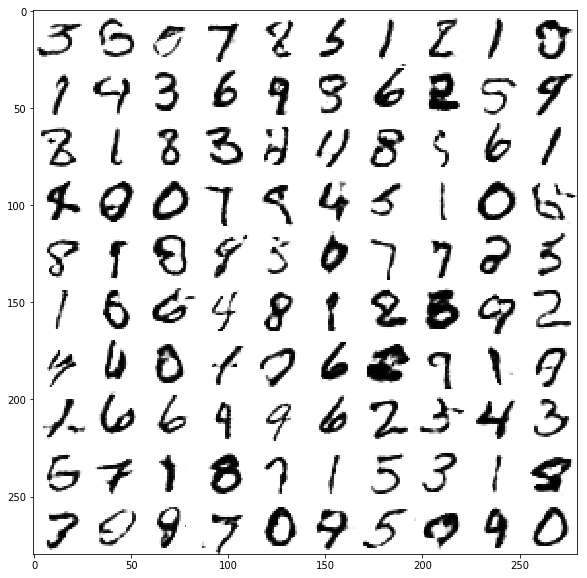

In [10]:
###  TESTING SESSION

# Generate images from noise, using the generator network.
n = examples_to_show
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, latent])
    # Generate image from noise.
    g = s.run(gen_sample, feed_dict={noise_input: z, training_true: False})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

